# Donald Trump's tweets sentiment analysis and correlation with approval ratings

This research consists of three parts:
1. Obtain dataset for Trump's tweets between 18/12/2018 and 22/2/2019
2. Obtain dataset for Trump's tweets within a period of 7 days (14/3/2019 and 21/3/2019)
3. Obtain tweets that mention him between 14/3/2019 and 21/3/2019 (1000 tweets each day)

# Research Question 1

1. Does the sentiment intensity of Trump’s tweets for the specific period in time correlate with approval rating changes: Is there a correlation between negative/positive tweets and corresponding fluctuations in approval rating?

## 1.1 Imports and API initialization

In [1]:
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Set2', font_scale=1.4, rc={"figure.figsize": [12, 8]})
import numpy as np
import datetime, json, logging, os, re, math
import preprocessor as pre
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize
import spacy, en_core_web_sm
nlp = en_core_web_sm.load()
from collections import Counter

In [3]:
logging.basicConfig(filename='logfile.log', level=logging.DEBUG, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

name = 'realDonaldTrump'

# dates range to collect tweets
start_date = datetime.datetime(2018, 12, 18, 0, 0, 0)
end_date = datetime.datetime(2019, 2, 22, 0, 0, 0)

consumer_key = ''
consumer_secret = ''

oauth_token = ''
oauth_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(oauth_token, oauth_token_secret)

# the are rate limits for the frequency of API calls for twitter, 
# wait_on_rate_limit flag helps us not to worry about it while collecting the data
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
print(api.me().name)

## 1.2 Tweets collection

Now we collect Trump's tweets from the specified date range. If already collected, read from file.

In [5]:
def collect_tweets(tweets, file):
    """
    collect all tweets for the specified account and time range,
    save results to file
    
    """
    tweets_temp = api.user_timeline(
        screen_name=name,
        count=200,
        include_rts='false',
        tweet_mode='extended')
    for tweet in tweets_temp:
        if tweet.created_at < end_date and tweet.created_at > start_date:
            tweets.append(tweet._json)

    while (tweets_temp[-1].created_at > start_date):
        tweets_temp = api.user_timeline(
            screen_name=name,
            count=200,
            max_id=tweets_temp[-1].id,
            include_rts='false',
            tweet_mode='extended')
        for tweet in tweets_temp:
            if tweet.created_at < end_date and tweet.created_at > start_date:
                tweets.append(tweet._json)

    json.dump(tweets, file, indent=2)

In [6]:
%%time
if os.path.isfile('trump_tweets.json') and not os.stat('trump_tweets.json').st_size == 0:
    logging.info('File trump_tweets.json already exists! Reading the file..')
    file = open('trump_tweets.json', 'r', encoding='utf8')
    tweets = json.load(file)
    file.close()
else:
    logging.info('Creating trump_tweets.json, collecting tweets..')
    file = open('trump_tweets.json', 'w', encoding='utf8')
    tweets = []
    collect_tweets(tweets, file)
    file.close()

Wall time: 18.6 ms


Create dataframe to store and process the data 

In [7]:
df = pd.DataFrame(data=[tweet['full_text'] for tweet in tweets], columns=['Text'])
df.head(10)

,Text
0,Senator John Cornyn has done an outstanding jo...
1,.@JussieSmollett - what about MAGA and the ten...
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...
3,....something that is so obviously the future....
4,"I want 5G, and even 6G, technology in the Unit..."
5,I have instructed Secretary of State Mike Pomp...
6,We have just built this powerful Wall in New M...
7,California now wants to scale back their alrea...
8,The New York Times reporting is false. They ar...
9,“If thinking that James Comey is not a good FB...


Let's see what attributes available for each tweet object looks like

In [8]:
print('id:',tweets[0]['id'])
print('date:',tweets[0]['created_at'])
print('likes:',tweets[0]['favorite_count'])
print('retweets:',tweets[0]['retweet_count'])
print(tweets[0]['entities'])

id: 1098676390780719104
date: Thu Feb 21 20:10:38 +0000 2019
likes: 101024
retweets: 21110
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}


Now let's add interesting attributes to the dataframe

In [9]:
df['len'] = np.array([len(tweet['full_text']) for tweet in tweets])
df['id'] = np.array([tweet['id'] for tweet in tweets])
df['Date'] = pd.DatetimeIndex(pd.to_datetime([tweet['created_at'] for tweet in tweets])).normalize()
df['Likes'] = np.array([tweet['favorite_count'] for tweet in tweets])
df['RTs'] = np.array([tweet['retweet_count'] for tweet in tweets])
df.head()

,Text,len,id,Date,Likes,RTs
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21 00:00:00+00:00,101024,21110
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21 00:00:00+00:00,222426,56149
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21 00:00:00+00:00,134130,31597
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21 00:00:00+00:00,125867,23394
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21 00:00:00+00:00,143746,28589


In [10]:
min(df.Date), max(df.Date)

(Timestamp('2018-12-18 00:00:00+0000', tz='UTC'),
 Timestamp('2019-02-21 00:00:00+0000', tz='UTC'))

In [11]:
df.shape

(561, 6)

## 1.3 Natural Language Processing

### 1.3.1 Data preprocessing

Now lets do some preprocessing to prepare it for the entities extraction

In [12]:
# remove @user mentions, # hashtag symbol, URLs, emoji etc.
# check the package documentation for info
# pre.set_options(pre.OPT.URL, pre.OPT.EMOJI, pre.OPT.MENTION, pre.OPT.RESERVED, pre.OPT.SMILEY, pre.OPT.NUMBER)
text_processed = df['Text'].apply(lambda s: pre.clean(s))

# removing all non alpha-numeric symbols
text_processed = text_processed.apply(lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))

# removing stop words
text_processed = text_processed.apply(
    lambda s: ' '.join(word for word in s.split() if word not in stop_words))


In [13]:
print('Before:\n' + df['Text'][29] + '\n\nAfter:\n' + text_processed[29])

Before:
We are here to proclaim that a new day is coming in Latin America. In Venezuela and across the Western Hemisphere, Socialism is DYING - and liberty, prosperity, and democracy are being REBORN...https://t.co/hPL5W48Pmg

After:
We proclaim new day coming Latin America In Venezuela across Western Hemisphere Socialism DYING liberty prosperity democracy REBORN


## 1.4 Sentiment Analysis

Now we'll calculate the sentiment intensity for each of Trump's tweets using VADER which is especially tailored to work with social media texts

In [14]:
analyzer = SentimentIntensityAnalyzer()

sentiment_intensity = df['Text'].apply(lambda s: analyzer.polarity_scores(s))
sentiment_intensity = sentiment_intensity.apply(pd.Series)
df = pd.concat([df, sentiment_intensity], axis=1)
df.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21 00:00:00+00:00,101024,21110,0.063,0.608,0.329,0.9425
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21 00:00:00+00:00,222426,56149,0.386,0.614,0.000,-0.8932
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21 00:00:00+00:00,134130,31597,0.000,1.000,0.000,0.0000
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21 00:00:00+00:00,125867,23394,0.000,0.702,0.298,0.9344
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21 00:00:00+00:00,143746,28589,0.076,0.743,0.180,0.7089


We mark the tweets as neutral/negative/positive based on the calculated sentiment intensity.

In [15]:
df.loc[(df['compound'] > -.05) &
       (df['compound'] < .05), 'Sentiment'] = 'neutral'
df.loc[df['compound'] <= -.05, 'Sentiment'] = 'negative'
df.loc[df['compound'] >= .05, 'Sentiment'] = 'positive'
df.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound,Sentiment
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21 00:00:00+00:00,101024,21110,0.063,0.608,0.329,0.9425,positive
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21 00:00:00+00:00,222426,56149,0.386,0.614,0.000,-0.8932,negative
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21 00:00:00+00:00,134130,31597,0.000,1.000,0.000,0.0000,neutral
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21 00:00:00+00:00,125867,23394,0.000,0.702,0.298,0.9344,positive
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21 00:00:00+00:00,143746,28589,0.076,0.743,0.180,0.7089,positive


Now lets take a look at the count and distribution of positive/negative tweets based on these marks.

In [16]:
Counter(df['Sentiment'])

Counter({'positive': 299, 'negative': 212, 'neutral': 50})

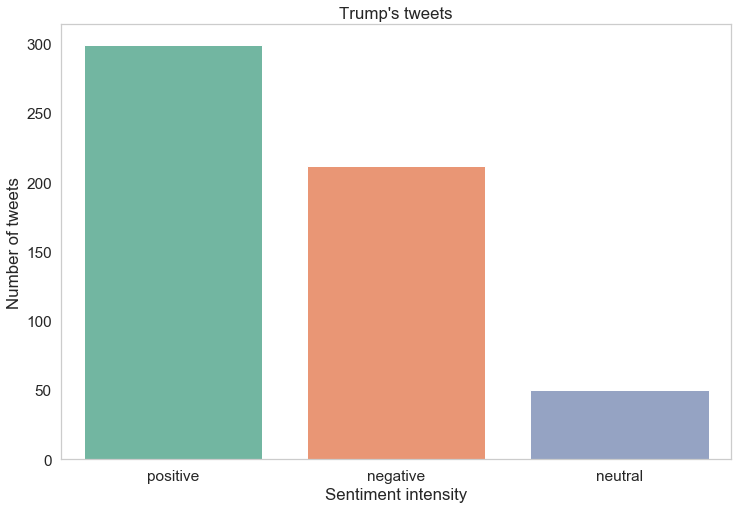

In [77]:
sns.countplot(df['Sentiment'])
plt.xlabel('Sentiment intensity')
plt.ylabel('Number of tweets')
plt.title('Trump\'s tweets')
plt.grid(False)

## 1.5 Entities extraction
Now after cleaning the data we can extract entities using SpaCy and NLTK and add it to the dataframe

To see the transcription for the entities codes check the SpaCy documentation

In [18]:
def get_entities(text):
    """
    Extract counts for each entity found in input text
    """
    return dict(Counter([s.label_ for s in nlp(text).ents]))

In [19]:
%%time
entities = text_processed.apply(lambda s: get_entities(s))
entities = entities.apply(pd.Series)

Wall time: 5.27 s


In [20]:
df = pd.concat([df, entities], axis=1)
df.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound,...,MONEY,ORDINAL,LOC,PRODUCT,TIME,LAW,EVENT,WORK_OF_ART,FAC,QUANTITY
0,Senator John Cornyn has done an outstanding jo...,231,1098676390780719104,2019-02-21 00:00:00+00:00,101024,21110,0.063,0.608,0.329,0.9425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,.@JussieSmollett - what about MAGA and the ten...,130,1098615818512941057,2019-02-21 00:00:00+00:00,222426,56149,0.386,0.614,0.000,-0.8932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,THE WALL IS UNDER CONSTRUCTION RIGHT NOW! http...,65,1098587583469228037,2019-02-21 00:00:00+00:00,134130,31597,0.000,1.000,0.000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,....something that is so obviously the future....,274,1098583029713420288,2019-02-21 00:00:00+00:00,125867,23394,0.000,0.702,0.298,0.9344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"I want 5G, and even 6G, technology in the Unit...",279,1098581869233344512,2019-02-21 00:00:00+00:00,143746,28589,0.076,0.743,0.180,0.7089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's take a look at the entities distributions for tweets with positive and negative sentiments to know what Trump tweets about and in which context.

(0, 250)

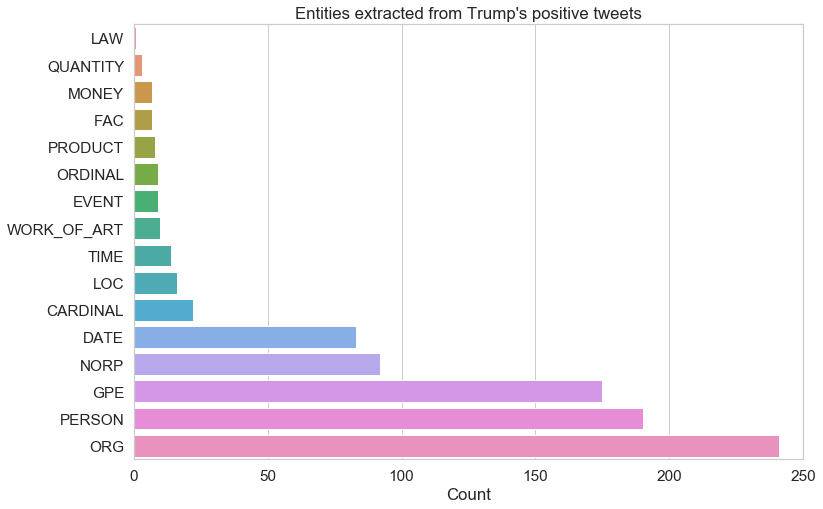

In [78]:
counters = {}
df_plot = df.loc[df['Sentiment'] == 'positive']

for column in entities.columns:
    counters.update({column: df_plot[column].sum()})

df_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')

sns.barplot(data=df_entities_distribution, x='Count', y=df_entities_distribution.index)
plt.title('Entities extracted from Trump\'s positive tweets')
plt.xlim(0,250)

(0, 250)

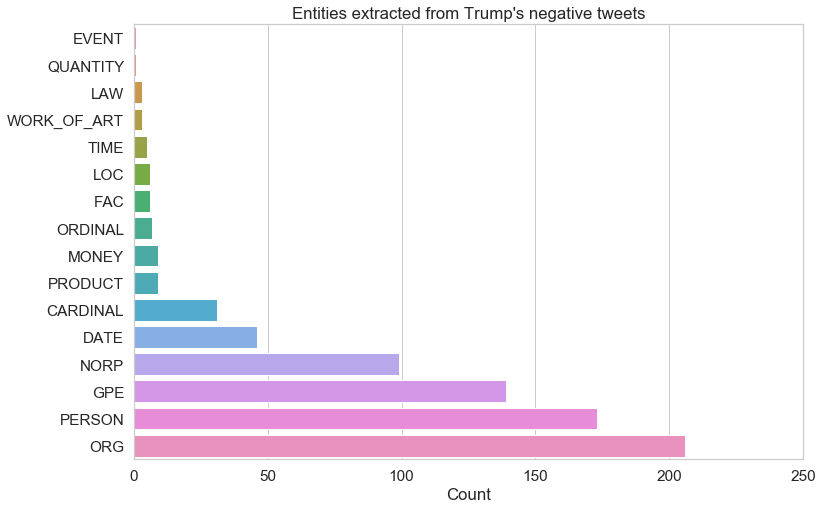

In [79]:
counters = {}
df_plot = df.loc[df['Sentiment'] == 'negative']

for column in entities.columns:
    counters.update({column: df_plot[column].sum()})

df_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')

sns.barplot(data=df_entities_distribution, x='Count', y=df_entities_distribution.index)
plt.title('Entities extracted from Trump\'s negative tweets')
plt.xlim(0,250)

## 1.5 Correlation with approval ratings
Approval ratings data from https://projects.fivethirtyeight.com/trump-approval-ratings/

In [23]:
# disapproval rating
rating = [
    52.3, 52.4, 52.6, 52.7, 52.8, 52.8, 52.9, 53, 53.3, 53.2, 53.2, 53.3, 53.4,
    53.4, 53.4, 53.5, 53.4, 53.4, 53.5, 53.5, 53.6, 53.8, 53.8, 53.9, 53.9,
    53.9, 54.3, 54.4, 54.5, 54.9, 55.2, 55.2, 55.2, 55.2, 55.3, 55.0, 55.9,
    55.9, 56, 56, 56, 55.9, 55.8, 55.9, 55.9, 55.9, 55.9, 56, 55.7, 55.6, 55.4,
    55.3, 55.1, 55.1, 55.1, 55.1, 54.9, 54.1, 54.1, 54.0, 53.7, 53.7, 53.8,
    53.6, 53.6, 53.2, 53
]

# approval rating
# rating = [100 - x for x in rating]

dates = pd.date_range(start_date, end_date)

df_rating = pd.DataFrame(rating, index=dates, columns=['Rating'])
df_rating.head(10)

,Rating
2018-12-18,52.3
2018-12-19,52.4
2018-12-20,52.6
2018-12-21,52.7
2018-12-22,52.8
2018-12-23,52.8
2018-12-24,52.9
2018-12-25,53.0
2018-12-26,53.3
2018-12-27,53.2


In [24]:
scatter_data = pd.DataFrame({'Date': df['Date'], 'Rate': 45, 'Sentiment': df['Sentiment']})
scatter_data.loc[scatter_data['Sentiment'] == 'negative', 'Rate'] = 54
scatter_data.loc[scatter_data['Sentiment'] == 'positive', 'Rate'] = 54.5
scatter_data.loc[scatter_data['Sentiment'] == 'neutral', 'Rate'] = 53.5

Text(0.5, 1.0, "Donald Trump's daily disapproval rate")

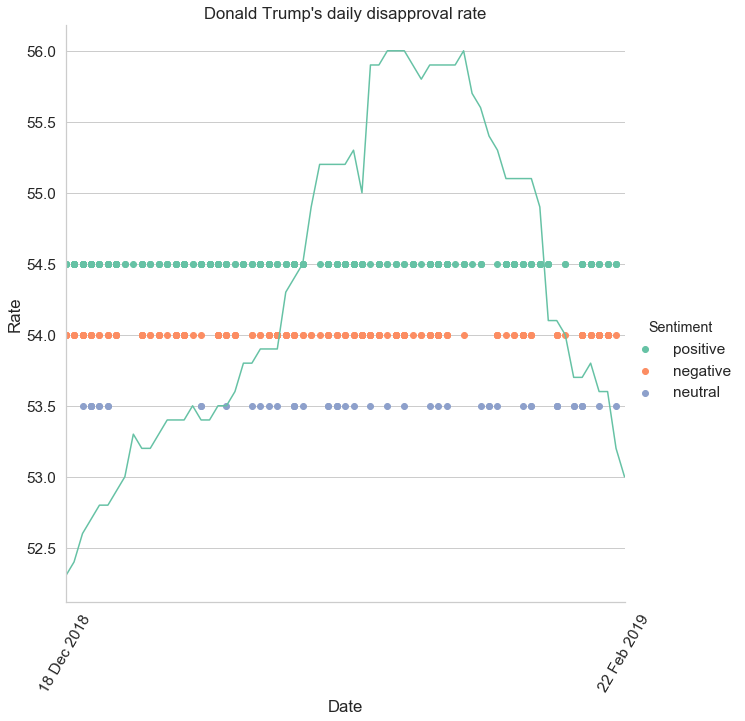

In [25]:
# sns.lineplot(df_rating.index, df_rating.Rating)
fig = sns.FacetGrid(data=scatter_data, hue='Sentiment', height=9)
fig.map(plt.scatter, 'Date', 'Rate').add_legend()
fig.axes[0, 0].plot(df_rating.index, df_rating.Rating)
plt.xticks(ticks=[df_rating.index[0], df_rating.index[-1]], labels=['18 Dec 2018', '22 Feb 2019'], rotation=60)
plt.xlim(df_rating.index[0], df_rating.index[-1])
plt.title('Donald Trump\'s daily disapproval rate')

In [82]:
df_plot = df.groupby(['Sentiment', 'Date']).size().reset_index().pivot(columns='Sentiment', index='Date', values=0)
# df_plot['negative'] = df_plot['negative'] + 27
# df_plot['neutral'] = df_plot['neutral'] + 27
# df_plot['positive'] = df_plot['positive'] + 27
df_plot.head()

Sentiment,negative,neutral,positive
Date,,,
2018-12-18 00:00:00+00:00,5.0,NaN,4.0
2018-12-19 00:00:00+00:00,4.0,NaN,8.0
2018-12-20 00:00:00+00:00,6.0,1.0,9.0
2018-12-21 00:00:00+00:00,5.0,4.0,11.0
2018-12-22 00:00:00+00:00,2.0,2.0,5.0


In [83]:
df_plot = df_plot[['positive', 'negative', 'neutral']]
df_plot.head()

Sentiment,positive,negative,neutral
Date,,,
2018-12-18 00:00:00+00:00,4.0,5.0,NaN
2018-12-19 00:00:00+00:00,8.0,4.0,NaN
2018-12-20 00:00:00+00:00,9.0,6.0,1.0
2018-12-21 00:00:00+00:00,11.0,5.0,4.0
2018-12-22 00:00:00+00:00,5.0,2.0,2.0


Text(0.5, 1.0, "Donald Trump's daily disapproval rate")

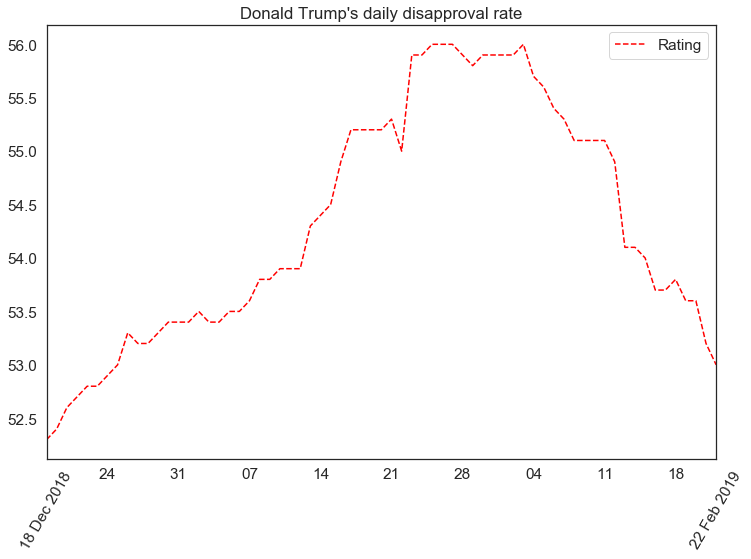

In [84]:
df_rating.plot(style='--r')
plt.xticks(ticks=[df_rating.index[0], df_rating.index[-1]], labels=['18 Dec 2018', '22 Feb 2019'], rotation=60)
plt.xlim(df_rating.index[0], df_rating.index[-1])
sns.set_style('white')
plt.title('Donald Trump\'s daily disapproval rate')

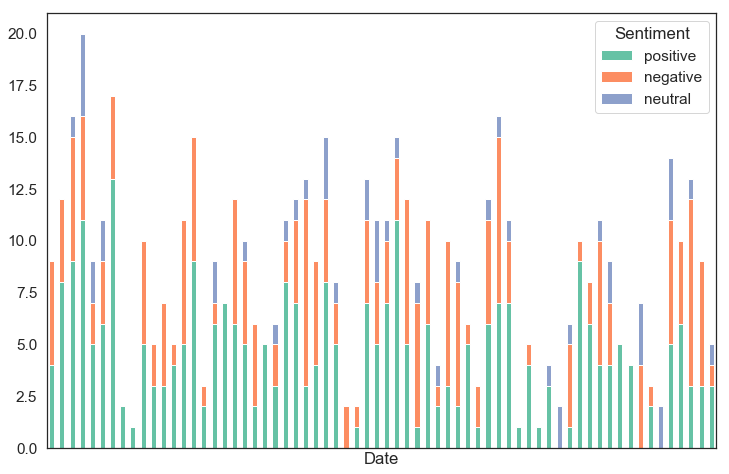

In [85]:
df_plot.plot(kind='bar', stacked=True)
sns.set(style='whitegrid', font_scale=1.4, palette='Set2', rc={"figure.figsize": [12, 8]})
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.grid(False)

Text(0.5, 1.0, "Trump's negative tweets daily")

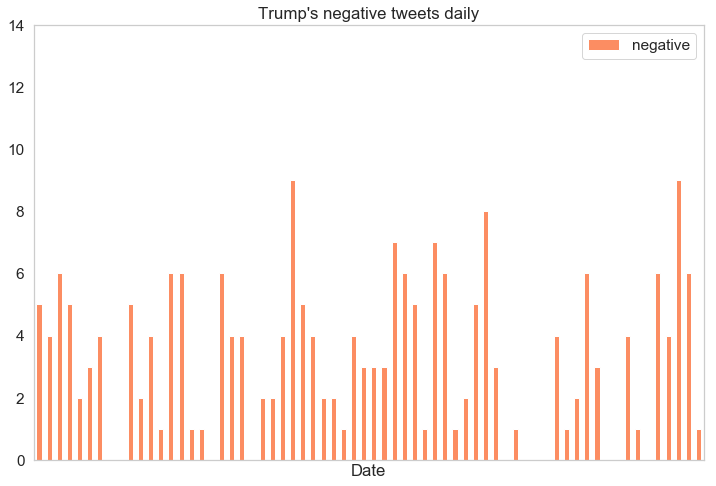

In [30]:
df_plot['negative'].plot(kind='bar', color=sns.color_palette()[1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylim(0, 14)
plt.grid(False)
plt.title('Trump\'s negative tweets daily')

Text(0.5, 1.0, "Trump's positive tweets daily")

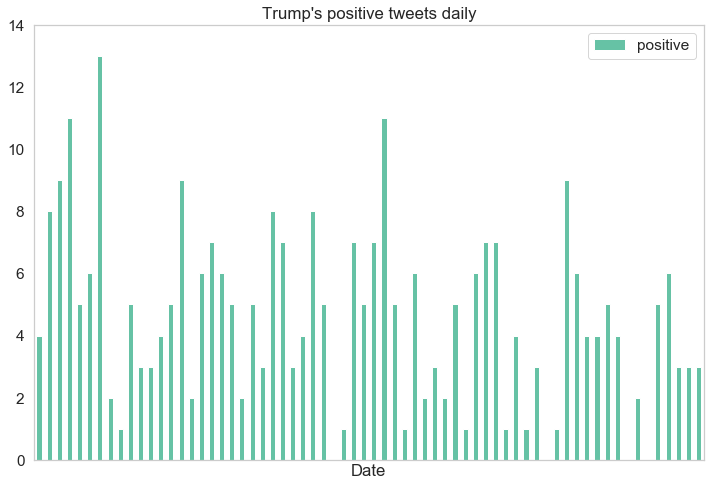

In [31]:
df_plot['positive'].plot(kind='bar', color=sns.color_palette()[0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.grid(False)
plt.ylim(0, 14)
plt.title('Trump\'s positive tweets daily')

# Research Question 2
2. Is there a correlation between the sentiment of Trump’s tweets and the sentiment of tweets that mention him?

## 2.1 Initialization
Due to limitations of the basic Twitter API, we define a new date range for our second research question

In [32]:
# dates range to collect tweets for a period of 7 days
start_date2 = datetime.datetime(2019, 3, 14, 0, 0, 0)
end_date2 = datetime.datetime(2019, 3, 21, 0, 0, 0)

## 2.2 Tweets collection
Now we collect Trump's tweets for the specified period and save them in a new file

In [33]:
%%time
if os.path.isfile('trump_tweets_week.json') and not os.stat('trump_tweets_week.json').st_size == 0:
    logging.info('File trump_tweets_week.json already exists! Reading the file..')
    file = open('trump_tweets_week.json', 'r', encoding='utf8')
    tweets = json.load(file)
    file.close()
else:
    logging.info('Creating trump_tweets_week.json, collecting tweets..')
    file = open('trump_tweets_week.json', 'w', encoding='utf8')
    tweets = []
    collect_tweets(tweets, file)
    file.close()

Wall time: 0 ns


Create a new dataframe to store and process the data 

In [34]:
df2 = pd.DataFrame(data=[tweet['full_text'] for tweet in tweets], columns=['Text'])
df2.head(10)

,Text
0,"George Conway, often referred to as Mr. Kellya..."
1,The Democrats are getting very “strange.” They...
2,Not a good situation! https://t.co/uaMcSrX4yM
3,....just the large States - the Cities would e...
4,Campaigning for the Popular Vote is much easie...
5,"Thank you @JesseBWatters, could not have said ..."
6,"Amazingly, CNN just released a poll at 71%, sa..."
7,https://t.co/95I4towyEP
8,I will be looking into this! #StopTheBias http...
9,"Facebook, Google and Twitter, not to mention t..."


In [35]:
print('id:',tweets[0]['id'])
print('date:',tweets[0]['created_at'])
print('likes:',tweets[0]['favorite_count'])
print('retweets:',tweets[0]['retweet_count'])
print(tweets[0]['entities'])

id: 1108335293671845888
date: Wed Mar 20 11:51:40 +0000 2019
likes: 86502
retweets: 19001
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}


In [36]:
df2['len'] = np.array([len(tweet['full_text']) for tweet in tweets])
df2['id'] = np.array([tweet['id'] for tweet in tweets])
df2['Date'] = pd.DatetimeIndex(pd.to_datetime([tweet['created_at'] for tweet in tweets])).normalize()
df2['Likes'] = np.array([tweet['favorite_count'] for tweet in tweets])
df2['RTs'] = np.array([tweet['retweet_count'] for tweet in tweets])
df2.head()

,Text,len,id,Date,Likes,RTs
0,"George Conway, often referred to as Mr. Kellya...",286,1108335293671845888,2019-03-20 00:00:00+00:00,86502,19001
1,The Democrats are getting very “strange.” They...,233,1108217768187449344,2019-03-20 00:00:00+00:00,98159,25851
2,Not a good situation! https://t.co/uaMcSrX4yM,45,1108214845294428161,2019-03-20 00:00:00+00:00,64043,19040
3,....just the large States - the Cities would e...,288,1108190837257764864,2019-03-20 00:00:00+00:00,102006,24900
4,Campaigning for the Popular Vote is much easie...,284,1108187855954870272,2019-03-20 00:00:00+00:00,78409,20547


In [37]:
min(df2.Date), max(df2.Date)

(Timestamp('2019-03-14 00:00:00+0000', tz='UTC'),
 Timestamp('2019-03-20 00:00:00+0000', tz='UTC'))

In [38]:
df2.shape

(79, 6)

## 2.3 Natural Language Processing (Trump's Tweets)

### 2.3.1 Data preprocessing

Now lets do some preprocessing again to prepare the new data for the entities extraction

In [39]:
# remove @user mentions, # hashtag symbol, URLs, emoji etc.
# check the package documentation for info
# pre.set_options(pre.OPT.URL, pre.OPT.EMOJI, pre.OPT.MENTION, pre.OPT.RESERVED, pre.OPT.SMILEY, pre.OPT.NUMBER)
text_processed_week = df2['Text'].apply(lambda s: pre.clean(s))

# removing all non alpha-numeric symbols
text_processed_week = text_processed_week.apply(lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))

# removing stop words
text_processed_week = text_processed_week.apply(lambda s: ' '.join(word for word in s.split() if word not in stop_words))

In [40]:
print('Before:\n' + df2['Text'][9] + '\n\nAfter:\n' + text_processed_week[9])

Before:
Facebook, Google and Twitter, not to mention the Corrupt Media, are sooo on the side of the Radical Left Democrats. But fear not, we will win anyway, just like we did before! #MAGA

After:
Facebook Google Twitter mention Corrupt Media sooo side Radical Left Democrats But fear win anyway like


## 2.4 Sentiment Analysis (7 Days)
Now we'll calculate the sentiment intensity for Trump's tweets for this period

In [41]:
analyzer = SentimentIntensityAnalyzer()

sentiment_intensity_week = df2['Text'].apply(lambda s: analyzer.polarity_scores(s))
sentiment_intensity_week = sentiment_intensity_week.apply(pd.Series)
df2 = pd.concat([df2, sentiment_intensity_week], axis=1)

df2.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound
0,"George Conway, often referred to as Mr. Kellya...",286,1108335293671845888,2019-03-20 00:00:00+00:00,86502,19001,0.285,0.652,0.062,-0.9519
1,The Democrats are getting very “strange.” They...,233,1108217768187449344,2019-03-20 00:00:00+00:00,98159,25851,0.000,0.730,0.270,0.8908
2,Not a good situation! https://t.co/uaMcSrX4yM,45,1108214845294428161,2019-03-20 00:00:00+00:00,64043,19040,0.473,0.527,0.000,-0.4015
3,....just the large States - the Cities would e...,288,1108190837257764864,2019-03-20 00:00:00+00:00,102006,24900,0.032,0.835,0.133,0.6908
4,Campaigning for the Popular Vote is much easie...,284,1108187855954870272,2019-03-20 00:00:00+00:00,78409,20547,0.000,0.698,0.302,0.9559


In [42]:
df2.loc[(df2['compound'] > -.05) & (df2['compound'] < .05), 'Sentiment'] = 'neutral'
df2.loc[df2['compound'] <= -.05, 'Sentiment'] = 'negative'
df2.loc[df2['compound'] >= .05, 'Sentiment'] = 'positive'
df2.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound,Sentiment
0,"George Conway, often referred to as Mr. Kellya...",286,1108335293671845888,2019-03-20 00:00:00+00:00,86502,19001,0.285,0.652,0.062,-0.9519,negative
1,The Democrats are getting very “strange.” They...,233,1108217768187449344,2019-03-20 00:00:00+00:00,98159,25851,0.000,0.730,0.270,0.8908,positive
2,Not a good situation! https://t.co/uaMcSrX4yM,45,1108214845294428161,2019-03-20 00:00:00+00:00,64043,19040,0.473,0.527,0.000,-0.4015,negative
3,....just the large States - the Cities would e...,288,1108190837257764864,2019-03-20 00:00:00+00:00,102006,24900,0.032,0.835,0.133,0.6908,positive
4,Campaigning for the Popular Vote is much easie...,284,1108187855954870272,2019-03-20 00:00:00+00:00,78409,20547,0.000,0.698,0.302,0.9559,positive


In [43]:
Counter(df2['Sentiment'])

Counter({'negative': 27, 'positive': 35, 'neutral': 17})

(0, 40)

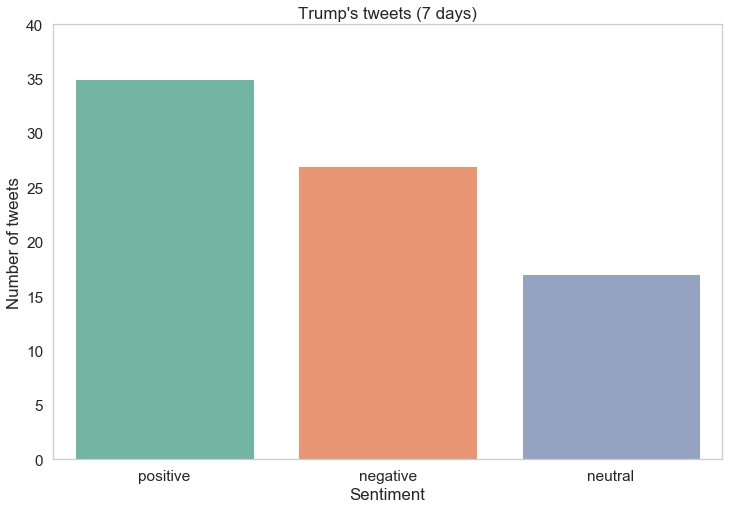

In [44]:
sns.countplot(df2['Sentiment'], order=['positive', 'negative', 'neutral'])
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.title('Trump\'s tweets (7 days)')
plt.grid(False)
plt.ylim(0, 40)

Text(0.5, 1.0, "Trump's tweets distribution")

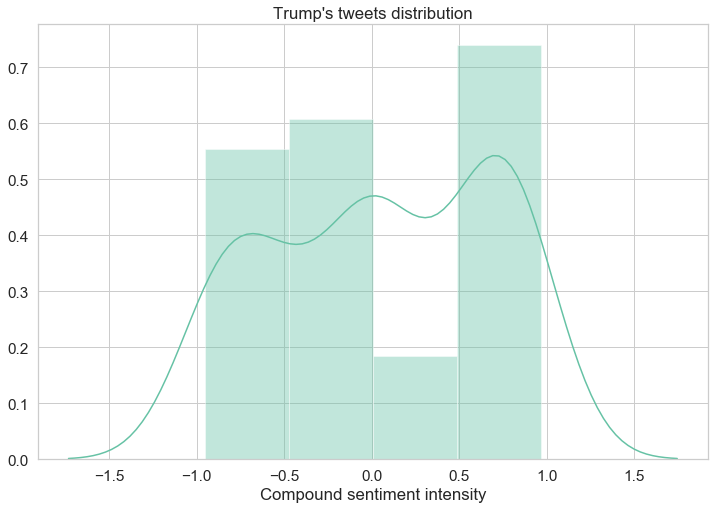

In [45]:
sns.distplot(df2['compound'])
plt.xlabel('Compound sentiment intensity')
plt.title('Trump\'s tweets distribution')

In [46]:
df2_plot = df2.groupby(['Sentiment', 'Date']).size().reset_index().pivot(columns='Sentiment', index='Date', values=0)
# df_plot['negative'] = df_plot['negative'] + 27
# df_plot['neutral'] = df_plot['neutral'] + 27
# df_plot['positive'] = df_plot['positive'] + 27
df2_plot.head()

Sentiment,negative,neutral,positive
Date,,,
2019-03-14 00:00:00+00:00,4.0,1.0,7.0
2019-03-15 00:00:00+00:00,5.0,3.0,4.0
2019-03-16 00:00:00+00:00,1.0,6.0,5.0
2019-03-17 00:00:00+00:00,8.0,1.0,5.0
2019-03-18 00:00:00+00:00,3.0,2.0,8.0


In [47]:
df2_plot = df2_plot[['positive', 'negative', 'neutral']]
df2_plot.head()

Sentiment,positive,negative,neutral
Date,,,
2019-03-14 00:00:00+00:00,7.0,4.0,1.0
2019-03-15 00:00:00+00:00,4.0,5.0,3.0
2019-03-16 00:00:00+00:00,5.0,1.0,6.0
2019-03-17 00:00:00+00:00,5.0,8.0,1.0
2019-03-18 00:00:00+00:00,8.0,3.0,2.0


Text(0.5, 1.0, "Trump's negative tweets daily (7 days)")

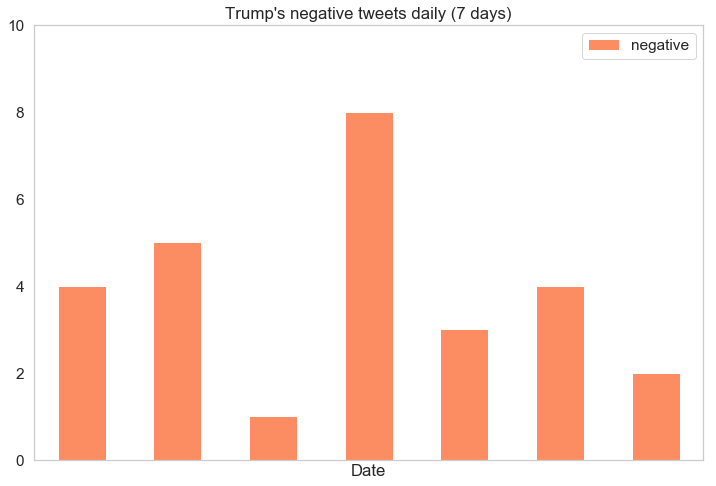

In [48]:
df2_plot['negative'].plot(kind='bar', color=sns.color_palette()[1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylim(0, 10)
plt.grid(False)
plt.title('Trump\'s negative tweets daily (7 days)')

Text(0.5, 1.0, "Trump's positive tweets daily (7 days)")

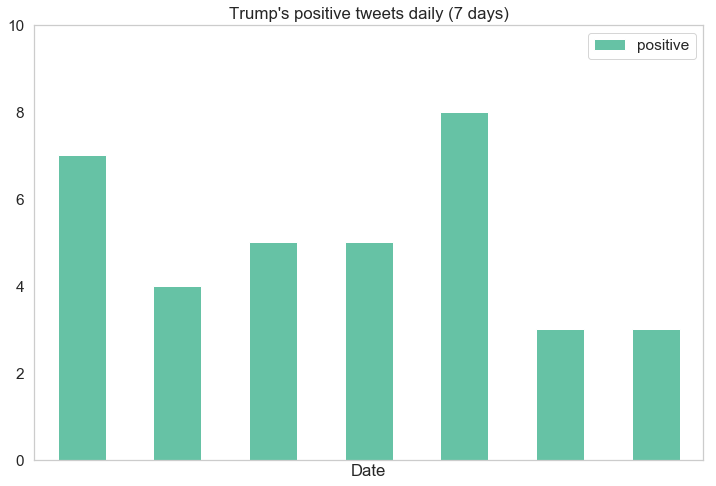

In [49]:
df2_plot['positive'].plot(kind='bar', color=sns.color_palette()[0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylim(0,10)
plt.grid(False)
plt.title('Trump\'s positive tweets daily (7 days)')

## 2.5 Entities extraction
Now after cleaning the data we can extract the entities again using SpaCy and NLTK and add it to the new dataframe

In [50]:
%%time
entities_week = text_processed_week.apply(lambda s: get_entities(s))
entities_week = entities_week.apply(pd.Series)

Wall time: 829 ms


In [51]:
df2 = pd.concat([df2, entities_week], axis=1)
df2.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound,...,NORP,PRODUCT,LOC,GPE,DATE,WORK_OF_ART,CARDINAL,ORDINAL,TIME,EVENT
0,"George Conway, often referred to as Mr. Kellya...",286,1108335293671845888,2019-03-20 00:00:00+00:00,86502,19001,0.285,0.652,0.062,-0.9519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Democrats are getting very “strange.” They...,233,1108217768187449344,2019-03-20 00:00:00+00:00,98159,25851,0.000,0.730,0.270,0.8908,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Not a good situation! https://t.co/uaMcSrX4yM,45,1108214845294428161,2019-03-20 00:00:00+00:00,64043,19040,0.473,0.527,0.000,-0.4015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,....just the large States - the Cities would e...,288,1108190837257764864,2019-03-20 00:00:00+00:00,102006,24900,0.032,0.835,0.133,0.6908,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Campaigning for the Popular Vote is much easie...,284,1108187855954870272,2019-03-20 00:00:00+00:00,78409,20547,0.000,0.698,0.302,0.9559,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's take a look at the entities distributions for tweets with positive and negative sentiments to know what Trump tweets about and in which context.

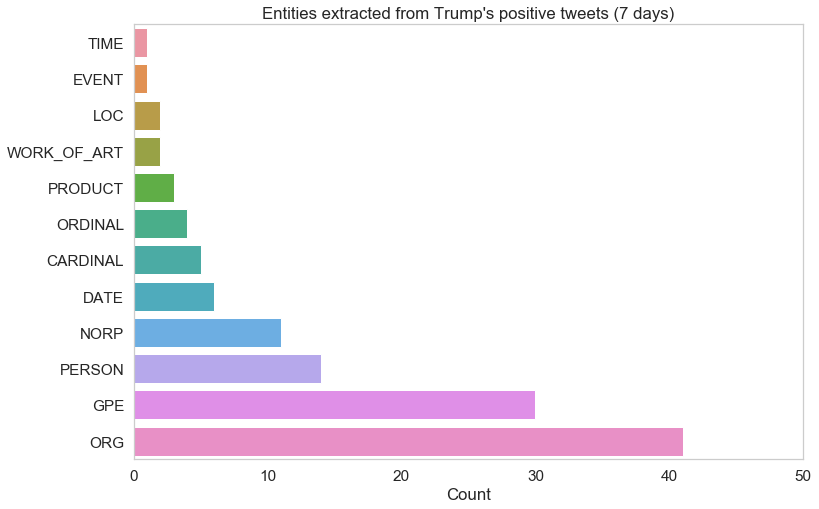

In [52]:
counters = {}
df2_plot = df2.loc[df2['Sentiment'] == 'positive']

for column in entities_week.columns:
    counters.update({column: df2_plot[column].sum()})

df2_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')

sns.barplot(data=df2_entities_distribution, x='Count', y=df2_entities_distribution.index)
plt.title('Entities extracted from Trump\'s positive tweets (7 days)')
plt.xlim(0,50)
plt.grid(False)

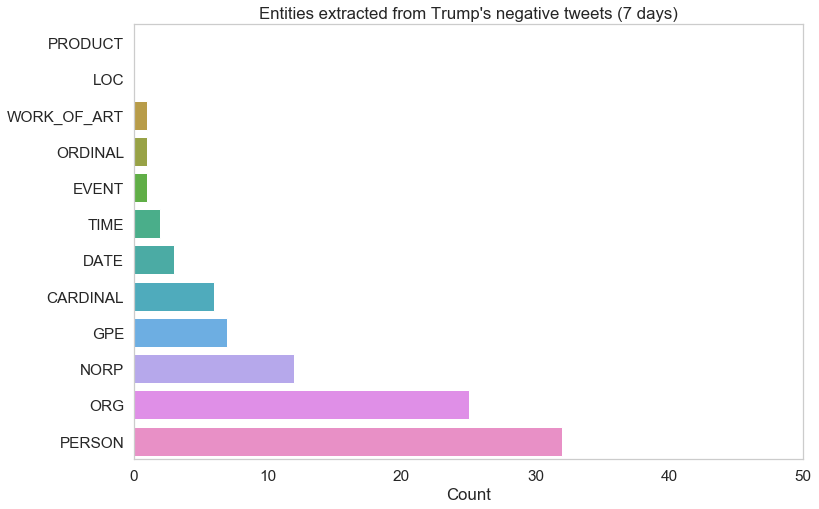

In [53]:
counters = {}
df2_plot = df2.loc[df2['Sentiment'] == 'negative']

for column in entities_week.columns:
    counters.update({column: df2_plot[column].sum()})

df2_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')

sns.barplot(data=df2_entities_distribution, x='Count', y=df2_entities_distribution.index)
plt.title('Entities extracted from Trump\'s negative tweets (7 days)')
plt.xlim(0,50)
plt.grid(False)

## 3.1 Collection of mentions

Now as we collected all Trump's tweets for the desired period, we can loop through the same period and actually collect tweets that contain mentions of him

In [54]:
def collect_mentions(tweets, file):
    """
    collect replies for all the collected tweets of the specified account,
    query gets 100 replies per page, 10 pages give 1000 replies in total,
    then compares with desired parameters,
    finally saves results to file.
    
    """
    for i in range(7):
        day=14+i
        until_date='2019-03-{}'.format(day)
        print(until_date)
        for status in tweepy.Cursor(
            api.search,
            # filter tweets by replies to @name and exclude retweets
            q='to:' + name + ' -filter:retweets',
            #since_id=tweet['id'],
            #count=10,
            until=until_date,
            # specifiy what type of search results you would prefer to receive. 
            # default is "mixed"
            result_type='recent',
            tweet_mode='extended').items(1000):
            #for status in page:
            if hasattr(status, 'in_reply_to_status_id_str'):
                    #if status.in_reply_to_status_id_str == tweet['id_str']:
                    #logging.info('Found a reply to the tweet with id=',
                                    #status.in_reply_to_status_id_str,
                                    #'text=' + status.full_text)
                replies.append(status._json)
                    #logging.info('Reply added to the list. Continue...')
    
    json.dump(replies, file, indent=2)

In [55]:
%%time
if os.path.isfile('mentions.json') and not os.stat('mentions.json').st_size == 0:
    logging.info('File mentions.json already exists! Reading the file..')
    file = open('mentions.json', 'r', encoding='utf8')
    replies = json.load(file)
    file.close()
else:
    logging.info('Creating mentions.json, collecting tweets..')
    file = open('mentions.json', 'w', encoding='utf8')
    replies = []
    collect_mentions(tweets, file)
    file.close()

Wall time: 481 ms


In [56]:
df_mentions = pd.DataFrame(data=[reply['full_text'] for reply in replies], columns=['Text'])
df_mentions.head(10)

,Text
0,@realDonaldTrump Let’s focus on sex traffickin...
1,"@realDonaldTrump I don't fly, it's just not na..."
2,@realDonaldTrump More lies from the dotard!
3,@realDonaldTrump @POTUS @FoxNews You should do...
4,"@realDonaldTrump @FoxNews You sound worried, t..."
5,@realDonaldTrump CONSPIRACY / #Treason: Just L...
6,@realDonaldTrump Support Trump
7,@realDonaldTrump Justice will be served when y...
8,@realDonaldTrump @FoxNews Mueller was hired to...
9,@realDonaldTrump I N D I V I D U A L N U M B...


In [57]:
print('id:',replies[0]['id'])
print('date:',replies[0]['created_at'])
print('likes:',replies[0]['favorite_count'])
print('retweets:',replies[0]['retweet_count'])
print(replies[0]['entities'])

id: 1105981867071848449
date: Wed Mar 13 23:59:59 +0000 2019
likes: 0
retweets: 0
{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [0, 16]}], 'urls': []}


In [58]:
df_mentions['len'] = np.array([len(reply['full_text']) for reply in replies])
df_mentions['id'] = np.array([reply['id'] for reply in replies])
df_mentions['Date'] = pd.DatetimeIndex(pd.to_datetime([reply['created_at'] for reply in replies])).normalize()
df_mentions['Likes'] = np.array([reply['favorite_count'] for reply in replies])
df_mentions['RTs'] = np.array([reply['retweet_count'] for reply in replies])
df_mentions.head()

,Text,len,id,Date,Likes,RTs
0,@realDonaldTrump Let’s focus on sex traffickin...,69,1105981867071848449,2019-03-13 00:00:00+00:00,0,0
1,"@realDonaldTrump I don't fly, it's just not na...",81,1105981865981345792,2019-03-13 00:00:00+00:00,0,0
2,@realDonaldTrump More lies from the dotard!,43,1105981864995680256,2019-03-13 00:00:00+00:00,2,0
3,@realDonaldTrump @POTUS @FoxNews You should do...,199,1105981864987246592,2019-03-13 00:00:00+00:00,0,0
4,"@realDonaldTrump @FoxNews You sound worried, t...",53,1105981862789505026,2019-03-13 00:00:00+00:00,0,0


In [59]:
df_mentions['Date'].value_counts()

2019-03-15 00:00:00+00:00    1000
2019-03-19 00:00:00+00:00    1000
2019-03-14 00:00:00+00:00    1000
2019-03-18 00:00:00+00:00    1000
2019-03-13 00:00:00+00:00    1000
2019-03-17 00:00:00+00:00    1000
2019-03-16 00:00:00+00:00    1000
Name: Date, dtype: int64

In [60]:
min(df_mentions.Date), max(df_mentions.Date)

(Timestamp('2019-03-13 00:00:00+0000', tz='UTC'),
 Timestamp('2019-03-19 00:00:00+0000', tz='UTC'))

In [61]:
df_mentions.shape

(7000, 6)

### 3.2 Natural Language Processing (Mentions)

### 3.2.1 Data preprocessing

Now lets do some preprocessing to prepare it for the entities extraction

In [62]:
# remove @user mentions, # hashtag symbol, URLs, emoji etc.
# check the package documentation for info
# pre.set_options(pre.OPT.URL, pre.OPT.EMOJI, pre.OPT.MENTION, pre.OPT.RESERVED, pre.OPT.SMILEY, pre.OPT.NUMBER)
text_processed_mentions = df_mentions['Text'].apply(lambda s: pre.clean(s))

# removing all non alpha-numeric symbols
text_processed_mentions = text_processed_mentions.apply(lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))

# removing stop words
text_processed_mentions = text_processed_mentions.apply(lambda s: ' '.join(word for word in s.split() if word not in stop_words))

In [63]:
print('Before:\n' + df_mentions['Text'][9] + '\n\nAfter:\n' + text_processed_mentions[9])

Before:
@realDonaldTrump I N D I V I D U A L   N U M B E R    O N E

After:
I N D I V I D U A L N U M B E R O N E


## 3.3 Sentiment Analysis
Now we'll calculate the sentiment intensity for tweets that mentions Trump

In [64]:
analyzer_mentions = SentimentIntensityAnalyzer()

sentiment_intensity_mentions = df_mentions['Text'].apply(lambda s: analyzer_mentions.polarity_scores(s))
sentiment_intensity_mentions = sentiment_intensity_mentions.apply(pd.Series)
df_mentions = pd.concat([df_mentions, sentiment_intensity_mentions], axis=1)

df_mentions.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound
0,@realDonaldTrump Let’s focus on sex traffickin...,69,1105981867071848449,2019-03-13 00:00:00+00:00,0,0,0.000,0.763,0.237,0.4215
1,"@realDonaldTrump I don't fly, it's just not na...",81,1105981865981345792,2019-03-13 00:00:00+00:00,0,0,0.150,0.850,0.000,-0.2755
2,@realDonaldTrump More lies from the dotard!,43,1105981864995680256,2019-03-13 00:00:00+00:00,2,0,0.404,0.596,0.000,-0.5244
3,@realDonaldTrump @POTUS @FoxNews You should do...,199,1105981864987246592,2019-03-13 00:00:00+00:00,0,0,0.072,0.694,0.234,0.6808
4,"@realDonaldTrump @FoxNews You sound worried, t...",53,1105981862789505026,2019-03-13 00:00:00+00:00,0,0,0.545,0.455,0.000,-0.7177


In [65]:
df_mentions.loc[(df_mentions['compound'] > -.05) & (df_mentions['compound'] < .05), 'Sentiment'] = 'neutral'
df_mentions.loc[df_mentions['compound'] <= -.05, 'Sentiment'] = 'negative'
df_mentions.loc[df_mentions['compound'] >= .05, 'Sentiment'] = 'positive'
df_mentions.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound,Sentiment
0,@realDonaldTrump Let’s focus on sex traffickin...,69,1105981867071848449,2019-03-13 00:00:00+00:00,0,0,0.000,0.763,0.237,0.4215,positive
1,"@realDonaldTrump I don't fly, it's just not na...",81,1105981865981345792,2019-03-13 00:00:00+00:00,0,0,0.150,0.850,0.000,-0.2755,negative
2,@realDonaldTrump More lies from the dotard!,43,1105981864995680256,2019-03-13 00:00:00+00:00,2,0,0.404,0.596,0.000,-0.5244,negative
3,@realDonaldTrump @POTUS @FoxNews You should do...,199,1105981864987246592,2019-03-13 00:00:00+00:00,0,0,0.072,0.694,0.234,0.6808,positive
4,"@realDonaldTrump @FoxNews You sound worried, t...",53,1105981862789505026,2019-03-13 00:00:00+00:00,0,0,0.545,0.455,0.000,-0.7177,negative


In [66]:
Counter(df_mentions['Sentiment'])

Counter({'positive': 2024, 'negative': 2344, 'neutral': 2632})

(0, 3000)

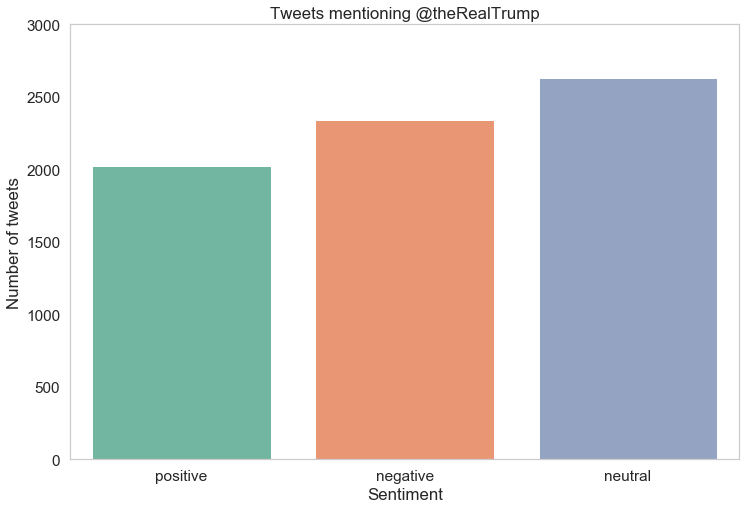

In [67]:
sns.countplot(df_mentions['Sentiment'], order=['positive', 'negative', 'neutral'])
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.title('Tweets mentioning @theRealTrump')
plt.grid(False)
plt.ylim(0, 3000)

Text(0.5, 1.0, "Replies to Trump's tweets distribution")

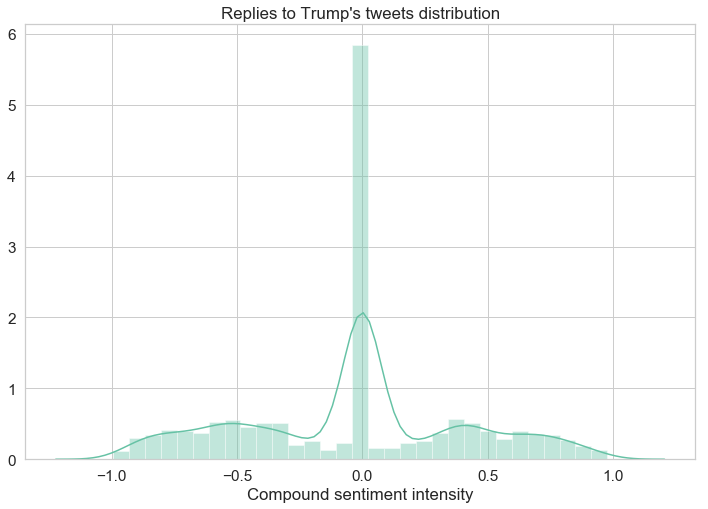

In [68]:
sns.distplot(df_mentions['compound'])
plt.xlabel('Compound sentiment intensity')
plt.title('Replies to Trump\'s tweets distribution')

In [69]:
df_mentions_plot = df_mentions.groupby(['Sentiment', 'Date']).size().reset_index().pivot(columns='Sentiment', index='Date', values=0)
# df_plot['negative'] = df_plot['negative'] + 27
# df_plot['neutral'] = df_plot['neutral'] + 27
# df_plot['positive'] = df_plot['positive'] + 27
df_mentions_plot.head()

Sentiment,negative,neutral,positive
Date,,,
2019-03-13 00:00:00+00:00,383,355,262
2019-03-14 00:00:00+00:00,271,443,286
2019-03-15 00:00:00+00:00,335,386,279
2019-03-16 00:00:00+00:00,379,360,261
2019-03-17 00:00:00+00:00,401,351,248


In [70]:
df_mentions_plot = df_mentions_plot[['positive', 'negative', 'neutral']]
df_mentions_plot.head()

Sentiment,positive,negative,neutral
Date,,,
2019-03-13 00:00:00+00:00,262,383,355
2019-03-14 00:00:00+00:00,286,271,443
2019-03-15 00:00:00+00:00,279,335,386
2019-03-16 00:00:00+00:00,261,379,360
2019-03-17 00:00:00+00:00,248,401,351


Text(0.5, 1.0, 'Negative mentions (7 days)')

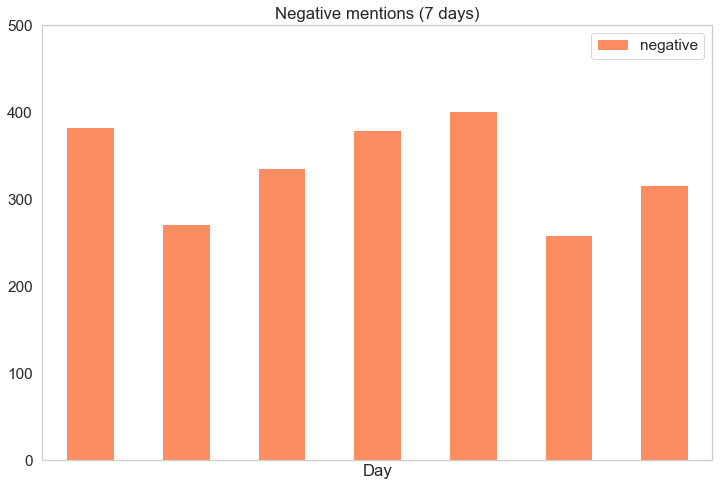

In [71]:
df_mentions_plot['negative'].plot(kind='bar', color=sns.color_palette()[1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylim(0, 500)
plt.grid(False)
plt.xlabel('Day')
plt.title('Negative mentions (7 days)')

Text(0.5, 1.0, 'Positive mentions (7 days)')

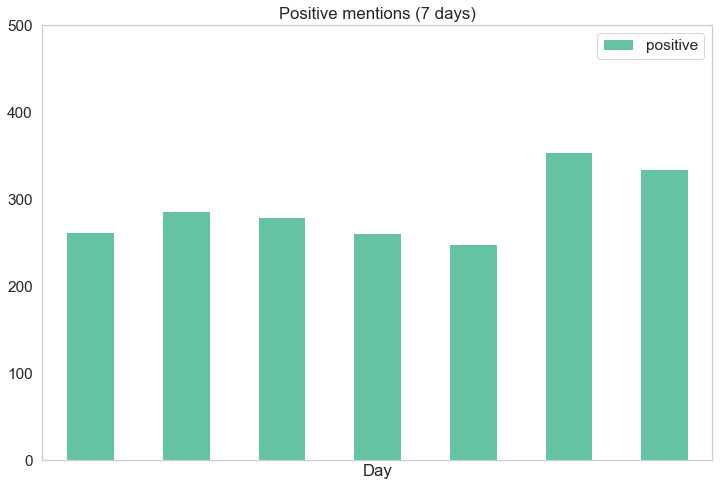

In [72]:
df_mentions_plot['positive'].plot(kind='bar', color=sns.color_palette()[0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylim(0, 500)
plt.grid(False)
plt.xlabel('Day')
plt.title('Positive mentions (7 days)')

## 3.4 Entities extraction

In [73]:
%%time
entities_mentions = text_processed_mentions.apply(lambda s: get_entities(s))
entities_mentions = entities_mentions.apply(pd.Series)

Wall time: 56.8 s


In [74]:
df_mentions = pd.concat([df_mentions, entities_mentions], axis=1)
df_mentions.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound,...,ORDINAL,LOC,CARDINAL,MONEY,FAC,LANGUAGE,LAW,TIME,EVENT,PERCENT
0,@realDonaldTrump Let’s focus on sex traffickin...,69,1105981867071848449,2019-03-13 00:00:00+00:00,0,0,0.000,0.763,0.237,0.4215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"@realDonaldTrump I don't fly, it's just not na...",81,1105981865981345792,2019-03-13 00:00:00+00:00,0,0,0.150,0.850,0.000,-0.2755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,@realDonaldTrump More lies from the dotard!,43,1105981864995680256,2019-03-13 00:00:00+00:00,2,0,0.404,0.596,0.000,-0.5244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,@realDonaldTrump @POTUS @FoxNews You should do...,199,1105981864987246592,2019-03-13 00:00:00+00:00,0,0,0.072,0.694,0.234,0.6808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"@realDonaldTrump @FoxNews You sound worried, t...",53,1105981862789505026,2019-03-13 00:00:00+00:00,0,0,0.545,0.455,0.000,-0.7177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Entities extracted from positive tweets mentioning Trump')

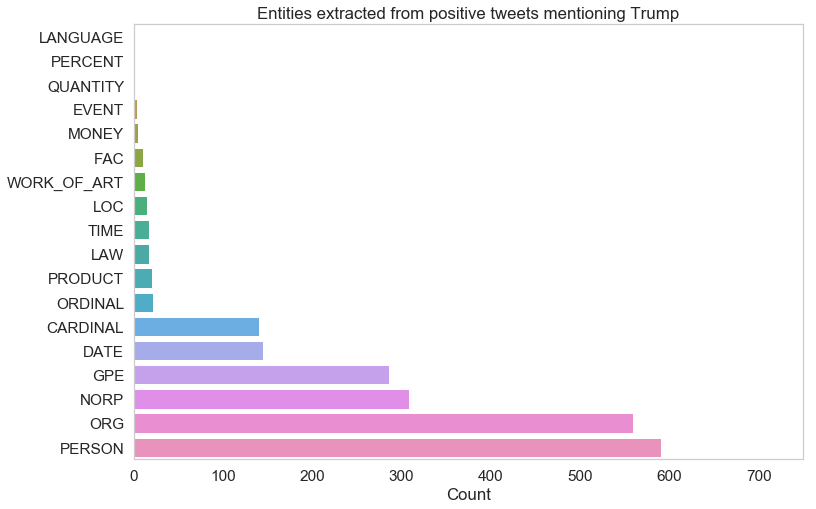

In [75]:
counters = {}
df_mentions_plot = df_mentions.loc[df_mentions['Sentiment'] == 'positive']

for column in entities_mentions.columns:
    counters.update({column: df_mentions_plot[column].sum()})

df_mentions_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')

sns.barplot(data=df_mentions_entities_distribution, x='Count', y=df_mentions_entities_distribution.index)
plt.grid(False)
plt.xlim(0,750)
plt.title('Entities extracted from positive tweets mentioning Trump')

Text(0.5, 1.0, 'Entities extracted from negative tweets mentioning Trump')

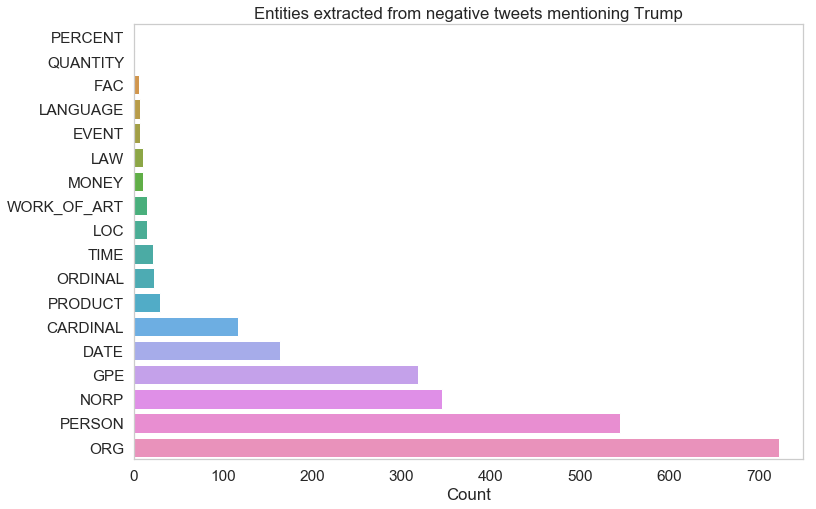

In [76]:
counters = {}
df_mentions_plot = df_mentions.loc[df_mentions['Sentiment'] == 'negative']

for column in entities_mentions.columns:
    counters.update({column: df_mentions_plot[column].sum()})

df_mentions_entities_distribution = pd.DataFrame.from_dict(counters, orient='index', columns=['Count']).sort_values(by='Count')

sns.barplot(data=df_mentions_entities_distribution, x='Count', y=df_mentions_entities_distribution.index)
plt.grid(False)
plt.xlim(0,750)
plt.title('Entities extracted from negative tweets mentioning Trump')